## ``dnn-inference`` in MNIST dataset

In [1]:
import sys
sys.path.append('..')

import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as K
import time
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam, SGD

In [2]:
np.random.seed(0)
num_classes = 2
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.vstack((x_train, x_test))
y = np.hstack((y_train, y_test))
ind = (y == 9) + (y == 7)
X, y = X[ind], y[ind]
X = X.astype('float32')
X += .01*abs(np.random.randn(14251, 28, 28))
y[y==7], y[y==9] = 0, 1

if K.image_data_format() == 'channels_first':
	X = X.reshape(x.shape[0], 1, img_rows, img_cols)
	input_shape = (1, img_rows, img_cols)
else:
	X = X.reshape(X.shape[0], img_rows, img_cols, 1)
	input_shape = (img_rows, img_cols, 1)

X /= 255.

# convert class vectors to binary class matrices
y = keras.utils.to_categorical(y, num_classes)

In [3]:
## define the learning models
def cnn():
	model = Sequential()
	model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
	model.add(Conv2D(64, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(num_classes, activation='softmax'))
	model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(0.0005), metrics=['accuracy'])
	return model

model, model_mask = cnn(), cnn()

In [11]:
## fitting param
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=15, restore_best_weights=True)

fit_params = {'callbacks': [es],
			  'epochs': 5,
			  'batch_size': 32,
			  'validation_split': .2,
			  'verbose': 0}

split_params = {'split': 'one-split',
				'perturb': None,
				'num_perm': 100,
				'ratio_grid': [.2, .4, .6, .8],
				'perturb_grid': [.001, .005, .01, .05, .1],
				'min_inf': 100,
				'min_est': 1000,
				'ratio_method': 'fuse',
				'cv_num': 1,
				'cp': 'min',
				'verbose': 1}

(AdaRatio) Est. Type 1 error: 0.000; p_value_mean: 0.555, inference sample ratio: 0.200, perturb: 0.001
0-th inference; Adaptive data splitting: n: 11401; m: 2850; perturb: 0.001
cv: 0; p_value: 0.164; diff: -0.001(0.056); metric: 0.003(0.056); metric_mask: 0.004(0.065)
cv: 1; p_value: 0.494; diff: -0.000(0.046); metric: 0.002(0.046); metric_mask: 0.002(0.046)
cv: 2; p_value: 0.639; diff: 0.000(0.050); metric: 0.002(0.049); metric_mask: 0.002(0.046)
accept H0 with p_value: 0.901
(AdaRatio) Est. Type 1 error: 0.000; p_value_mean: 0.649, inference sample ratio: 0.200, perturb: 0.001
1-th inference; Adaptive data splitting: n: 11401; m: 2850; perturb: 0.001
cv: 0; p_value: 0.173; diff: -0.001(0.062); metric: 0.004(0.059); metric_mask: 0.005(0.067)
cv: 1; p_value: 0.128; diff: -0.001(0.050); metric: 0.002(0.046); metric_mask: 0.003(0.056)
cv: 2; p_value: 0.212; diff: -0.001(0.046); metric: 0.002(0.042); metric_mask: 0.002(0.049)
accept H0 with p_value: 0.389
(AdaRatio) Est. Type 1 error: 0

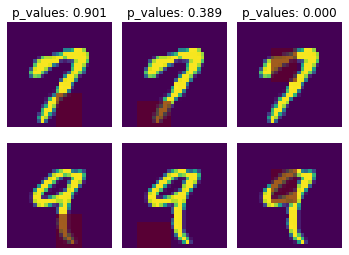

P-values: [0.9008369329524851, 0.38855124291861903, 1.0087345089116913e-15]


In [12]:
## Inference based on dnn_inference
from dnn_inference import DnnT
## testing based on learning models
inf_feats = [[np.arange(19,28), np.arange(13,20)], [np.arange(21,28), np.arange(4, 13)],[np.arange(7,16), np.arange(9,16)]]
shiing = DnnT(inf_cov=inf_feats, model=model, model_mask=model_mask, change='mask', eva_metric='zero-one')
p_value_tmp = shiing.testing(X, y, cv_num=3, cp='hommel', fit_params=fit_params, split_params=split_params)
## visualize testing results
shiing.visual(X,y)
print('P-values: %s' %p_value_tmp)